In [72]:
import numpy as np
import pandas as pd

from IPython.core.pylabtools import figsize
import seaborn as sns

from sklearn import model_selection
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

### преобразовала исходные данные в DataFrame

In [73]:
users = pd.read_csv('users.csv')
game_result = pd.read_csv('game_results.csv')

### объединила два набора данных один, куда попали все зарегистрированные пользователи

In [74]:
df = pd.merge(left=users, right=game_result, left_on='id', right_on='user_id')
df = df.drop(["id_x", "id_y"], axis =1) # удалила  повторяющихся столбцов,которые образовались из-за объединения

In [75]:
df

,create_time,user_id,timestamp,winner,length,magic_used,player_cards,round,type
0,2019-11-10 00:57:10,218490,2019-11-10 01:14:52,1,375,7,52,1,1
1,2019-11-10 00:57:10,218490,2019-11-10 01:23:06,1,475,3,41,2,1
2,2019-11-10 00:57:10,218490,2019-11-10 01:31:24,1,476,0,13,3,1
3,2019-11-10 00:57:10,218490,2019-11-10 01:38:43,1,329,2,52,1,1
4,2019-11-10 00:57:10,218490,2019-11-10 01:45:48,1,389,2,20,2,1
...,...,...,...,...,...,...,...,...,...
787061,2020-04-09 23:10:04,234754,2020-04-10 00:09:04,1,199,0,52,2,1
787062,2020-04-09 23:10:04,234754,2020-04-10 00:12:07,1,151,0,52,3,1
787063,2020-04-09 23:10:04,234754,2020-04-11 17:24:03,1,264,2,52,1,1
787064,2020-04-09 23:10:04,234754,2020-04-11 17:26:32,1,129,0,52,2,1


### оставила в наборе данных только операции пользователей за 24 часа после регистрации согласно условию задания

In [76]:
df['timestamp']= pd.to_datetime(df['timestamp']) 
df['create_time'] = pd.to_datetime(df['create_time'])

dff = df.loc[(df["timestamp"] - df["create_time"]) < "0 days 23:59:59"] 

In [77]:
dff

,create_time,user_id,timestamp,winner,length,magic_used,player_cards,round,type
0,2019-11-10 00:57:10,218490,2019-11-10 01:14:52,1,375,7,52,1,1
1,2019-11-10 00:57:10,218490,2019-11-10 01:23:06,1,475,3,41,2,1
2,2019-11-10 00:57:10,218490,2019-11-10 01:31:24,1,476,0,13,3,1
3,2019-11-10 00:57:10,218490,2019-11-10 01:38:43,1,329,2,52,1,1
4,2019-11-10 00:57:10,218490,2019-11-10 01:45:48,1,389,2,20,2,1
...,...,...,...,...,...,...,...,...,...
787058,2020-04-09 23:06:27,234753,2020-04-09 23:29:02,1,317,0,3,2,1
787059,2020-04-09 23:06:27,234753,2020-04-09 23:29:59,0,57,0,0,3,1
787060,2020-04-09 23:10:04,234754,2020-04-10 00:05:07,1,323,1,52,1,1
787061,2020-04-09 23:10:04,234754,2020-04-10 00:09:04,1,199,0,52,2,1


In [78]:
df.ftypes #информация про каждый признак данных 

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: DataFrame.ftypes is deprecated and will be removed in a future version. Use DataFrame.dtypes instead.
  """Entry point for launching an IPython kernel.


create_time     datetime64[ns]:dense
user_id                  int64:dense
timestamp       datetime64[ns]:dense
winner                   int64:dense
length                   int64:dense
magic_used               int64:dense
player_cards             int64:dense
round                    int64:dense
type                     int64:dense
dtype: object

### миниВывод = категориальных признаков нет, то есть не нужно их преобразовывать в численные признаки, так как многие модели не умеют с ними работать 
### + нужно преобразовать timestamp и create_time в тип datetime64[ns] для будущего сравнения

In [79]:
### проверка на пропущенные значения = таковые отсутствуют
dff.isnull().sum()

create_time     0
user_id         0
timestamp       0
winner          0
length          0
magic_used      0
player_cards    0
round           0
type            0
dtype: int64

### построение тепловой карты, для проверки зависимости признаков друг от друга = избыточных признаков не обнаружино, оставляем все в наборе данных¶

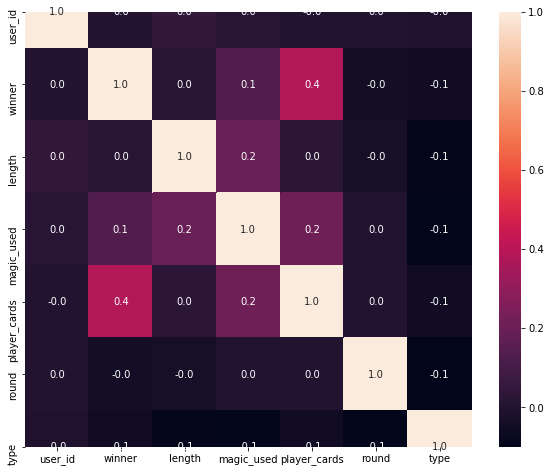

In [80]:
figsize(10,8)
svm = sns.heatmap(dff.corr(),annot = True, fmt ='.1f')
figure = svm.get_figure()
figure.savefig('svm_conf.png', dpi=200)

In [81]:
#prl = sns.pairplot(dff)

### набор данных, содержащих целевую переменную, преобразовала в датафрейм

In [82]:
predictions = pd.read_csv("predictions.csv")

In [83]:
predictions

,id,prediction
0,218490,0
1,218493,1
2,218499,0
3,218507,1
4,218508,0
...,...,...
3995,234738,1
3996,234743,1
3997,234752,0
3998,234753,1


In [84]:
dataset = pd.merge(left=dff, right=predictions, left_on='user_id', right_on='id')

In [85]:
dataset

,create_time,user_id,timestamp,winner,length,magic_used,player_cards,round,type,id,prediction
0,2019-11-10 00:57:10,218490,2019-11-10 01:14:52,1,375,7,52,1,1,218490,0
1,2019-11-10 00:57:10,218490,2019-11-10 01:23:06,1,475,3,41,2,1,218490,0
2,2019-11-10 00:57:10,218490,2019-11-10 01:31:24,1,476,0,13,3,1,218490,0
3,2019-11-10 00:57:10,218490,2019-11-10 01:38:43,1,329,2,52,1,1,218490,0
4,2019-11-10 00:57:10,218490,2019-11-10 01:45:48,1,389,2,20,2,1,218490,0
...,...,...,...,...,...,...,...,...,...,...,...
52705,2020-04-09 23:06:27,234753,2020-04-09 23:29:02,1,317,0,3,2,1,234753,1
52706,2020-04-09 23:06:27,234753,2020-04-09 23:29:59,0,57,0,0,3,1,234753,1
52707,2020-04-09 23:10:04,234754,2020-04-10 00:05:07,1,323,1,52,1,1,234754,0
52708,2020-04-09 23:10:04,234754,2020-04-10 00:09:04,1,199,0,52,2,1,234754,0


In [86]:
dataset['timestamp'] = dataset['timestamp'].values.astype(float)
dataset['create_time'] = dataset['create_time'].values.astype(float)

dataset["datetime"] = dataset["timestamp"] - dataset["create_time"]

In [87]:
dataset = dataset.drop(["timestamp", "create_time", "id"], axis = 1)

In [88]:
dataset = dataset.groupby("user_id", as_index=False).aggregate({"length" : ["min", "max"], "magic_used": ["min", "max", "mean"], "player_cards": ["min", "max"], "round": ["count", "max"], "datetime" : [ "max", "mean"], "prediction": "first"})

In [89]:
dataset.columns = ['_'.join(col) for col in dataset.columns]

In [90]:
dataset

,user_id_,length_min,length_max,magic_used_min,magic_used_max,magic_used_mean,player_cards_min,player_cards_max,round_count,round_max,datetime_max,datetime_mean,prediction_first
0,218490,232,1162,0,7,0.605263,0,52,38,3,8.633600e+13,5.302779e+13,0
1,218493,365,541,0,8,2.285714,17,52,7,3,6.009000e+12,4.418429e+12,1
2,218499,85,152,0,0,0.000000,8,52,3,3,6.290000e+11,4.623333e+11,0
3,218507,49,271,0,7,2.500000,0,52,4,3,1.062000e+12,8.330000e+11,1
4,218508,222,403,0,6,1.666667,10,52,12,3,3.347700e+13,2.452283e+13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3816,234738,90,237,0,0,0.000000,0,7,3,3,9.080000e+11,7.540000e+11,1
3817,234743,137,304,0,3,2.000000,10,52,5,3,2.303000e+12,1.678000e+12,1
3818,234752,96,232,0,0,0.000000,2,52,70,3,7.040200e+13,2.060013e+13,0
3819,234753,57,436,0,0,0.000000,0,15,3,3,1.412000e+12,1.246333e+12,1


# task

In [91]:
task = pd.merge(left=df, right=predictions, left_on='user_id', right_on='id', how='left', indicator=True)
task = task.loc[task["_merge"] != 'both']
task

,create_time,user_id,timestamp,winner,length,magic_used,player_cards,round,type,id,prediction,_merge
381,2019-11-10 01:32:13,218492,2019-11-10 01:42:48,1,297,2,52,1,1,NaN,NaN,left_only
382,2019-11-10 01:32:13,218492,2019-11-10 01:49:17,1,368,0,4,2,1,NaN,NaN,left_only
383,2019-11-10 01:32:13,218492,2019-11-10 01:54:27,1,284,0,52,3,1,NaN,NaN,left_only
799,2019-11-10 11:15:00,218535,2019-11-10 11:23:17,1,278,1,52,1,1,NaN,NaN,left_only
800,2019-11-10 11:15:00,218535,2019-11-10 11:27:19,1,218,0,52,2,1,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...
786747,2020-04-09 20:34:06,234734,2020-04-09 21:59:18,1,186,2,52,2,1,NaN,NaN,left_only
786748,2020-04-09 20:34:06,234734,2020-04-09 22:03:42,1,236,0,8,3,1,NaN,NaN,left_only
786794,2020-04-09 21:58:48,234747,2020-04-09 22:05:23,1,178,2,16,1,1,NaN,NaN,left_only
786795,2020-04-09 21:58:48,234747,2020-04-09 22:08:52,1,175,0,52,2,1,NaN,NaN,left_only


In [92]:
task.sort_values(by = ['user_id']).reset_index(drop = True)
task = task.drop(['id', 'prediction', '_merge'], axis = 1)

In [93]:
task

,create_time,user_id,timestamp,winner,length,magic_used,player_cards,round,type
381,2019-11-10 01:32:13,218492,2019-11-10 01:42:48,1,297,2,52,1,1
382,2019-11-10 01:32:13,218492,2019-11-10 01:49:17,1,368,0,4,2,1
383,2019-11-10 01:32:13,218492,2019-11-10 01:54:27,1,284,0,52,3,1
799,2019-11-10 11:15:00,218535,2019-11-10 11:23:17,1,278,1,52,1,1
800,2019-11-10 11:15:00,218535,2019-11-10 11:27:19,1,218,0,52,2,1
...,...,...,...,...,...,...,...,...,...
786747,2020-04-09 20:34:06,234734,2020-04-09 21:59:18,1,186,2,52,2,1
786748,2020-04-09 20:34:06,234734,2020-04-09 22:03:42,1,236,0,8,3,1
786794,2020-04-09 21:58:48,234747,2020-04-09 22:05:23,1,178,2,16,1,1
786795,2020-04-09 21:58:48,234747,2020-04-09 22:08:52,1,175,0,52,2,1


In [94]:
task = task.reset_index()
task = task.drop(['index'], axis = 1)
task

,create_time,user_id,timestamp,winner,length,magic_used,player_cards,round,type
0,2019-11-10 01:32:13,218492,2019-11-10 01:42:48,1,297,2,52,1,1
1,2019-11-10 01:32:13,218492,2019-11-10 01:49:17,1,368,0,4,2,1
2,2019-11-10 01:32:13,218492,2019-11-10 01:54:27,1,284,0,52,3,1
3,2019-11-10 11:15:00,218535,2019-11-10 11:23:17,1,278,1,52,1,1
4,2019-11-10 11:15:00,218535,2019-11-10 11:27:19,1,218,0,52,2,1
...,...,...,...,...,...,...,...,...,...
143945,2020-04-09 20:34:06,234734,2020-04-09 21:59:18,1,186,2,52,2,1
143946,2020-04-09 20:34:06,234734,2020-04-09 22:03:42,1,236,0,8,3,1
143947,2020-04-09 21:58:48,234747,2020-04-09 22:05:23,1,178,2,16,1,1
143948,2020-04-09 21:58:48,234747,2020-04-09 22:08:52,1,175,0,52,2,1


In [95]:
task.user_id.nunique()

899

In [96]:
task['timestamp'] = task['timestamp'].values.astype(float)
task['create_time'] = task['create_time'].values.astype(float)

task["datetime"] = task["timestamp"] - task["create_time"]

In [97]:
task = task.drop(["timestamp", "create_time"], axis = 1)

In [98]:
task = task.groupby("user_id", as_index=False).aggregate({"length" : ["min", "max"], "magic_used": ["min", "max", "mean"], "player_cards": ["min", "max"], "round": ["count", "max"], "datetime" : [ "max", "mean"]})

In [99]:
task.columns = ['_'.join(col) for col in task.columns]

In [100]:
task

,user_id_,length_min,length_max,magic_used_min,magic_used_max,magic_used_mean,player_cards_min,player_cards_max,round_count,round_max,datetime_max,datetime_mean
0,218492,284,368,0,2,0.666667,4,52,3,3,1.334000e+12,9.976667e+11
1,218535,85,278,0,1,0.333333,0,52,3,3,8.240000e+11,6.866667e+11
2,218557,57,325,0,1,0.222222,0,52,9,3,2.899230e+14,9.733789e+13
3,218559,74,565,0,6,0.209150,0,52,153,3,2.559831e+15,1.577417e+15
4,218591,124,260,0,5,2.000000,0,52,3,3,9.130000e+11,7.476667e+11
...,...,...,...,...,...,...,...,...,...,...,...,...
894,234692,11,964,0,10,0.026276,0,52,1332,3,2.591346e+15,1.641229e+15
895,234698,414,1065,0,6,1.692308,2,52,13,3,3.419620e+14,1.059172e+14
896,234722,56,56,0,0,0.000000,0,0,1,1,6.480000e+11,6.480000e+11
897,234734,180,257,0,3,0.833333,8,52,12,3,5.376000e+12,3.495417e+12


### соотношение классов целевой переменной = так как класс "0" значительно превосходит "1", то точность Accuracy не подойдет для оценки модели, лучше использовать ROC AUC.¶

In [101]:
dataset.groupby(["prediction_first"]).aggregate({"prediction_first" : "count"}) #соотношение классов

,prediction_first
prediction_first,
0,2662
1,1159


# study

In [102]:
train_X = dataset.drop(["prediction_first"], axis = 1)
train_y = dataset["prediction_first"]

#разбили на обуч. и тест. выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_X, train_y, test_size=0.25)

In [103]:
model = LGBMClassifier()
model.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [104]:
grid_parameters_LGBM = { 
        'n_estimators': [10, 20, 30, 80],
        'learning_rate': [0.8, 1, 1.2],
        'reg_lambda': [1.1, 1.2, 1.3]}
grid_LGBM = model_selection.GridSearchCV(
        estimator=model,
        param_grid=grid_parameters_LGBM,
        cv = 3,
        n_jobs=-1, 
        verbose=2
    )
fitted_model = grid_LGBM.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 101 out of 108 | elapsed:   23.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   23.8s finished


In [105]:
# получение лучшего набора
print (grid_LGBM.best_params_)

{'learning_rate': 1, 'n_estimators': 80, 'reg_lambda': 1.2}


In [106]:
model = LGBMClassifier(learning_rate = 1, n_estimators = 90,  reg_lambda = 1, max_depth = 1)

In [107]:
n_scores = cross_val_score(model, train_X, train_y, scoring='roc_auc', cv=3, n_jobs=-1, error_score='raise')
print('roc_auc: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

roc_auc: 0.711 (0.060)


In [108]:
model.fit(train_X, train_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=1, max_depth=1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=90, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [109]:
predictions = model.predict(X_test)

In [110]:
res = model.predict(task)
res = pd.DataFrame(res)

In [111]:
res

,0
0,1
1,1
2,0
3,0
4,1
...,...
894,0
895,0
896,1
897,0


In [112]:
#Переименовала столбцы
res.columns = ['prediction']
task['predictoin'] = res['prediction']

In [113]:
task = task.drop(["length_min", "length_max", "magic_used_min", "magic_used_max", "magic_used_mean", "player_cards_min", "player_cards_max", "round_count", "round_max", "datetime_max", "datetime_mean"], axis = 1)

In [114]:
task

,user_id_,predictoin
0,218492,1
1,218535,1
2,218557,0
3,218559,0
4,218591,1
...,...,...
894,234692,0
895,234698,0
896,234722,1
897,234734,0


In [115]:
task.to_csv('my_result.csv', index = None)